In [1]:
# training a small FGNET on MNIST data

In [2]:
from __future__ import print_function

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
from scipy import stats

import torch_helper_lib as th

import json
import pickle

In [4]:
# random seeds
# torch.manual_seed(1665)
# np.random.seed(3266)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [5]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = False
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

# manualy set cuda device
# torch.cuda.set_device(1)

CUDA Available:  True
Using device: cpu


In [6]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [7]:
# MNIST dataset and dataloader declaration
# transforms does both the conversion from 0-255 to 0-1
# and normalizes by the precomputed mean and std

batch_size = 2048

mnist_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../MNIST-dataset', train=True, download=False, 
                   transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=batch_size, shuffle=True)

mnist_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../MNIST-dataset', train=False, download=False, 
                   transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=batch_size, shuffle=False)

Shape: torch.Size([60000, 28, 28])
type: <type 'numpy.ndarray'>
shape: torch.Size([28, 28])
Label: 0
type: <class 'torch.Tensor'>


<IPython.core.display.Javascript object>


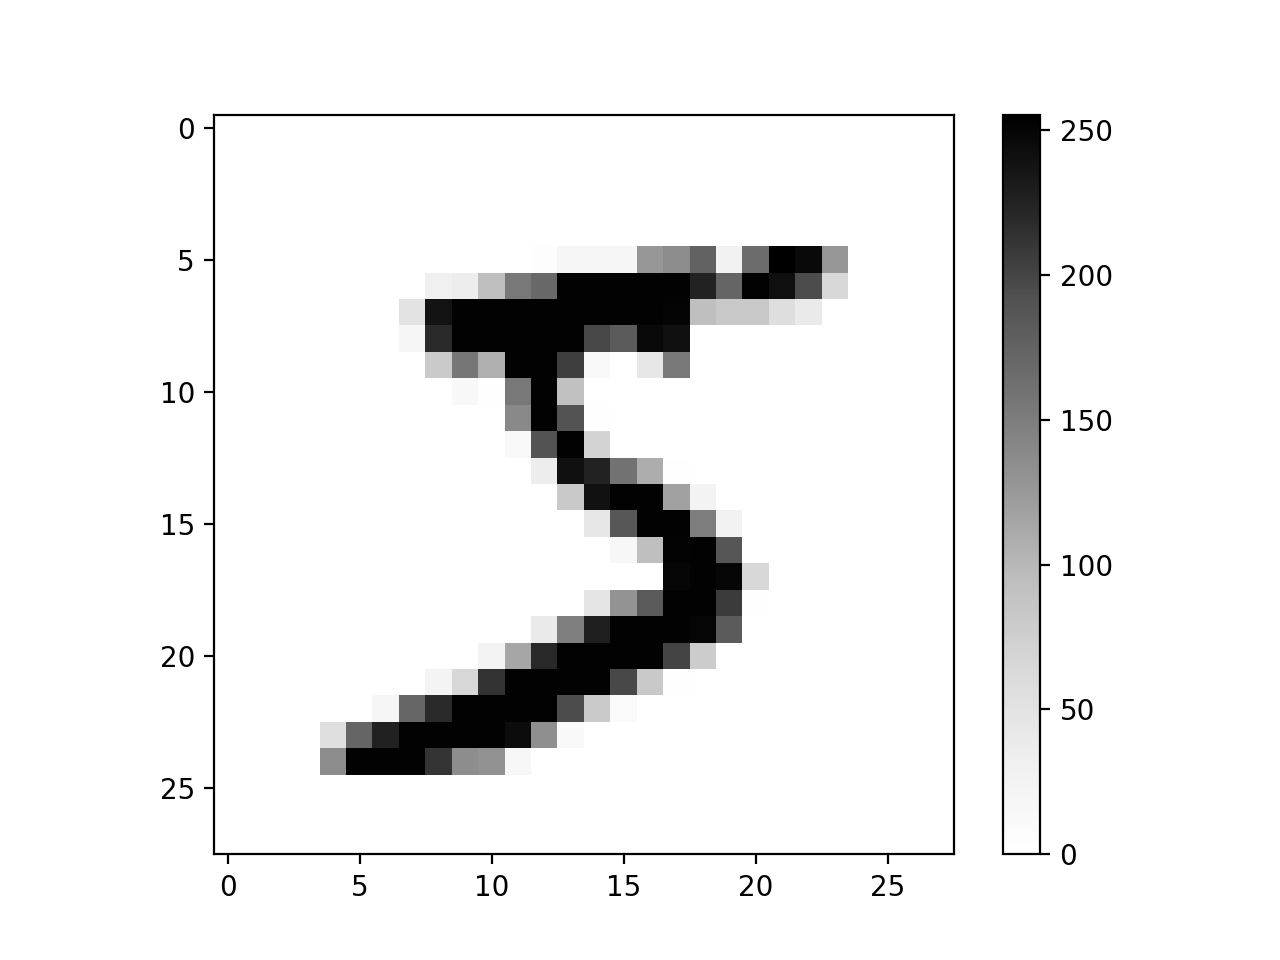

In [8]:
# show an example
print("Shape:", mnist_train_loader.dataset.train_data.shape)
x = mnist_train_loader.dataset.train_data[0]
print("type:", type(x.numpy()))
print("shape:", x.shape)
# print("sample:", x.numpy())

y = mnist_train_loader.dataset.train_labels[1]
print("Label:",y.numpy())
print("type:", type(y))

plt.imshow(x, cmap=plt.cm.get_cmap('Greys'))
plt.colorbar()
plt.show()

(28, 28)
[[-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296]
 [-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296]
 [-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
 

<IPython.core.display.Javascript object>


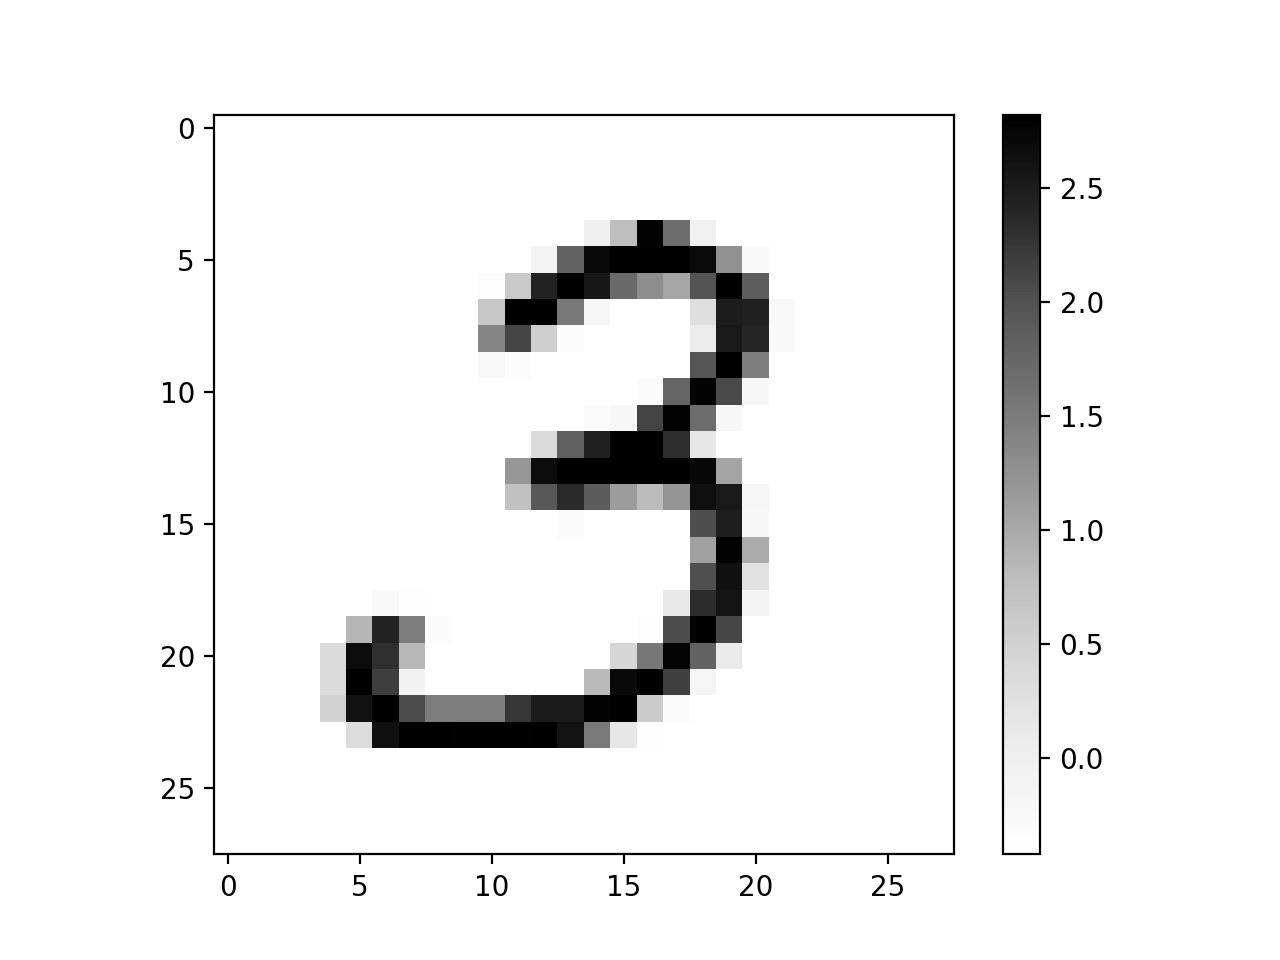

In [9]:
# check data loader values post transform (random because the loader shuffles)
for batch_idx, (data, target) in enumerate(mnist_train_loader):
    x = data[0][0].numpy()
    print(np.shape(x))
    print(x)
    plt.imshow(x, cmap=plt.cm.get_cmap('Greys'))
    plt.colorbar()
    plt.show()
    break

In [10]:
# create model to be trained
size = [128] # should get 90% acc minimum
fgn_model = th.Feedforward_FGN_net(28*28,10,size).to(device)

In [11]:
# include number of sigs in lmbda?
t_params = sum(p.numel() for p in fgn_model.parameters() if p.requires_grad)
print(t_params)
lmbda = 1.0/(len(mnist_train_loader.dataset)+t_params)
print(lmbda)


# training loss function
def training_loss_func(model, output, target):
    
    # normal NLL loss
    nll_loss = F.nll_loss(output, target.long())
#     print(nll_loss)

#     sum of sigma squares loss
#     sig_loss = lmbda*torch.sum(model.fl.sigs)
#     sig_loss = lmbda*torch.sum(model.state_dict()['fl.sigs'])
#     print(type(sig_loss.grad_fn))
#     sigs  = torch.nn.Parameter(torch.Tensor(), requires_grad = True).to(device)
#     print(type(sigs.grad_fn))

    for p in model.named_parameters():
        if 'sigs' in p[0]:
            try:
                sig_loss += torch.sum(p[1]**2)
            except:
                sig_loss = torch.sum(p[1]**2)
#             sigs = torch.cat((sigs, fgn_model.state_dict()[key]))
#     print(type(sigs.grad_fn))
    sig_loss = lmbda*sig_loss
#     print(type(sig_loss.grad_fn))


    return 1.0*nll_loss + 1.0*sig_loss

# number of correct pred function for fgnet
def fgn_pred_func(output, target):
    pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct = pred.eq(target.long().view_as(pred)).sum().item()
    return correct

203402
3.79647838665e-06


In [12]:
print("Final layer sigmas:",fgn_model.fl.sigs)
print("Final layer centers:",fgn_model.fl.centers)
print("Final layer weights:",fgn_model.fl.weights)

Final layer sigmas: Parameter containing:
tensor([127.0404, 128.1222, 127.3385, 127.7884, 127.2631, 129.0760, 128.7724,
        128.6265, 128.3648, 128.4669], requires_grad=True)
Final layer centers: Parameter containing:
tensor([[ 0.0003, -0.0089,  0.0098,  ...,  0.0021, -0.0050,  0.0022],
        [ 0.0010,  0.0072,  0.0081,  ...,  0.0004,  0.0059, -0.0013],
        [ 0.0100, -0.0029, -0.0096,  ..., -0.0012,  0.0063, -0.0029],
        ...,
        [ 0.0015,  0.0063,  0.0048,  ...,  0.0072,  0.0084,  0.0045],
        [ 0.0046,  0.0042,  0.0065,  ...,  0.0096,  0.0016, -0.0049],
        [-0.0028, -0.0071, -0.0023,  ..., -0.0069,  0.0017, -0.0053]],
       requires_grad=True)
Final layer weights: Parameter containing:
tensor([[  0.3831,  -0.5329,   4.1779,  ...,   0.1798,  -2.7564,  -5.6383],
        [  6.3748,  -3.8975,  -0.5518,  ...,   6.8249,  -7.1593,  -4.6840],
        [ -1.9540,  -9.3641,   1.8483,  ...,   8.8813,   3.6659,  -9.7396],
        ...,
        [ 10.4560,  -3.4455,  -3.

In [13]:
print(fgn_model.state_dict())

OrderedDict([('hidden_layers.0.weights', tensor([[ -2.9465,   3.6876,  -4.9438,  ...,  27.0505,  24.5708, -12.0356],
        [ -0.6504,   4.3191,   3.5900,  ...,  -2.9088,  19.7239, -21.4170],
        [  1.4341,  17.1010, -17.1238,  ...,  -4.2599,  10.9326,  -3.7381],
        ...,
        [ 20.8168,  15.4350,  22.3747,  ...,   9.2823,  15.1119,   5.7776],
        [ -9.4957,  15.3146,  10.2276,  ..., -12.6520,  11.5224,  -0.4961],
        [-15.5291, -23.0851,  -6.9379,  ...,  -4.3272,  11.8288,  14.8437]])), ('hidden_layers.0.centers', tensor([[ 0.0058, -0.0029, -0.0064,  ...,  0.0010,  0.0073, -0.0075],
        [ 0.0063,  0.0012, -0.0057,  ...,  0.0078, -0.0055,  0.0017],
        [-0.0020,  0.0088,  0.0077,  ...,  0.0034, -0.0084,  0.0021],
        ...,
        [ 0.0098, -0.0079,  0.0046,  ..., -0.0055, -0.0019,  0.0049],
        [-0.0095, -0.0029,  0.0033,  ...,  0.0092, -0.0080, -0.0013],
        [-0.0062, -0.0049, -0.0006,  ...,  0.0095,  0.0053,  0.0093]])), ('hidden_layers.0.sigs'

In [14]:
# some needed parameters
train_epochs = 3 

In [15]:
# optimizer for all params except sigma
# optimizer = optim.SGD(filter(lambda p: p.requires_grad, fgn_model.parameters()), lr=0.01, momentum=0.5, nesterov=True)
# optimizer = optim.Adam(filter(lambda p: p.requires_grad, fgn_model.parameters()), lr=0.01)
# optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, fgn_model.parameters()), momentum=0.8)
optimizer = optim.RMSprop([p for name,p in fgn_model.named_parameters() 
                           if p.requires_grad 
                           and 'sigs' not in name 
                           and 'hidden' in name], 
                          momentum=0.9)
# optimizer = optim.SGD([p for name,p in fgn_model.named_parameters() if p.requires_grad and 'sigs' in name], lr=0.99, momentum=0.8, nesterov=True)

In [16]:
fgn_train_res = []
print(len(fgn_train_res))

0


In [17]:
print(len(fgn_train_res))

0


In [18]:
latest_res = th.train(fgn_model, device, mnist_train_loader, training_loss_func, optimizer, epochs=train_epochs, save_hist=2, verbose=True, pred_func=fgn_pred_func, test_loader=mnist_test_loader)

if len(fgn_train_res) < 0 :
    for key in fgn_train_res.keys():
        fgn_train_res[key].extend(latest_res[key])
else:
    fgn_train_res = latest_res

Epoch 0 Train set - Average loss: 390.9552, Accuracy: 5963/60000 (10%)
Test set - Average loss: 389.3529, Accuracy: 1009/10000 (10%)
Epoch 1 Train set - Average loss: 388.9814, Accuracy: 5949/60000 (10%)
Test set - Average loss: 389.3529, Accuracy: 1009/10000 (10%)
Epoch 2 Train set - Average loss: 388.9814, Accuracy: 5949/60000 (10%)
Test set - Average loss: 389.3529, Accuracy: 1009/10000 (10%)


In [19]:
print("Final layer sigmas:",fgn_model.fl.sigs)
print("Final layer centers:",fgn_model.fl.centers)

Final layer sigmas: Parameter containing:
tensor([127.0404, 128.1222, 127.3385, 127.7884, 127.2631, 129.0760, 128.7724,
        128.6265, 128.3648, 128.4669], requires_grad=True)
Final layer centers: Parameter containing:
tensor([[ 0.0003, -0.0089,  0.0098,  ...,  0.0021, -0.0050,  0.0022],
        [ 0.0010,  0.0072,  0.0081,  ...,  0.0004,  0.0059, -0.0013],
        [ 0.0100, -0.0029, -0.0096,  ..., -0.0012,  0.0063, -0.0029],
        ...,
        [ 0.0015,  0.0063,  0.0048,  ...,  0.0072,  0.0084,  0.0045],
        [ 0.0046,  0.0042,  0.0065,  ...,  0.0096,  0.0016, -0.0049],
        [-0.0028, -0.0071, -0.0023,  ..., -0.0069,  0.0017, -0.0053]],
       requires_grad=True)


In [20]:
for m in fgn_model.named_parameters():
    if 'sigs' in m[0]:
        print(m[0])
        print(m[1])

hidden_layers.0.sigs
Parameter containing:
tensor([783.5074, 781.4183, 777.1375, 791.0733, 778.6382, 787.6999, 781.4620,
        782.1115, 777.2509, 777.0474, 784.8851, 777.9572, 790.4730, 790.3410,
        791.3693, 784.6048, 779.4468, 787.0969, 778.3047, 782.7977, 781.5771,
        777.4600, 788.0695, 785.2401, 780.9316, 785.2848, 782.6837, 788.0363,
        788.4697, 789.7445, 788.9297, 790.0630, 786.8002, 783.7260, 782.0250,
        784.7070, 786.4454, 784.1536, 791.5189, 783.8951, 787.0724, 780.0267,
        778.8948, 790.6887, 785.6005, 781.1562, 776.4516, 784.9099, 776.1951,
        781.6681, 780.4025, 783.4739, 785.5714, 787.8063, 780.9942, 786.2128,
        783.1327, 790.6563, 791.5481, 786.7122, 778.9253, 777.7603, 791.7355,
        787.8431, 776.6000, 787.6280, 780.3192, 776.3623, 783.8992, 781.4802,
        791.5848, 787.9260, 781.6167, 790.7037, 779.6404, 790.4423, 779.2216,
        783.8725, 781.6260, 780.1346, 790.3262, 789.9050, 784.2202, 782.4926,
        776.3112, 777

In [21]:
for m in fgn_model.named_parameters():
    if 'centers' in m[0]:
        print(m[0])
        print(m[1])

hidden_layers.0.centers
Parameter containing:
tensor([[-0.9937,  0.9967, -1.0060,  ...,  1.0009,  1.0071, -1.0073],
        [-0.9936,  1.0011,  0.9942,  ..., -0.9921,  0.9944, -0.9982],
        [ 1.2389,  1.2362, -1.2172,  ..., -1.2177,  1.2197, -1.2183],
        ...,
        [-0.9901, -1.0078, -0.9953,  ..., -1.0054, -1.0018, -0.9950],
        [-1.0094,  0.9970,  1.0032,  ..., -0.9908,  0.9919, -1.0012],
        [-1.0061, -1.0048, -1.0005,  ..., -0.9905,  1.0052,  1.0092]],
       requires_grad=True)
fl.centers
Parameter containing:
tensor([[ 0.0003, -0.0089,  0.0098,  ...,  0.0021, -0.0050,  0.0022],
        [ 0.0010,  0.0072,  0.0081,  ...,  0.0004,  0.0059, -0.0013],
        [ 0.0100, -0.0029, -0.0096,  ..., -0.0012,  0.0063, -0.0029],
        ...,
        [ 0.0015,  0.0063,  0.0048,  ...,  0.0072,  0.0084,  0.0045],
        [ 0.0046,  0.0042,  0.0065,  ...,  0.0096,  0.0016, -0.0049],
        [-0.0028, -0.0071, -0.0023,  ..., -0.0069,  0.0017, -0.0053]],
       requires_grad=True)

<IPython.core.display.Javascript object>


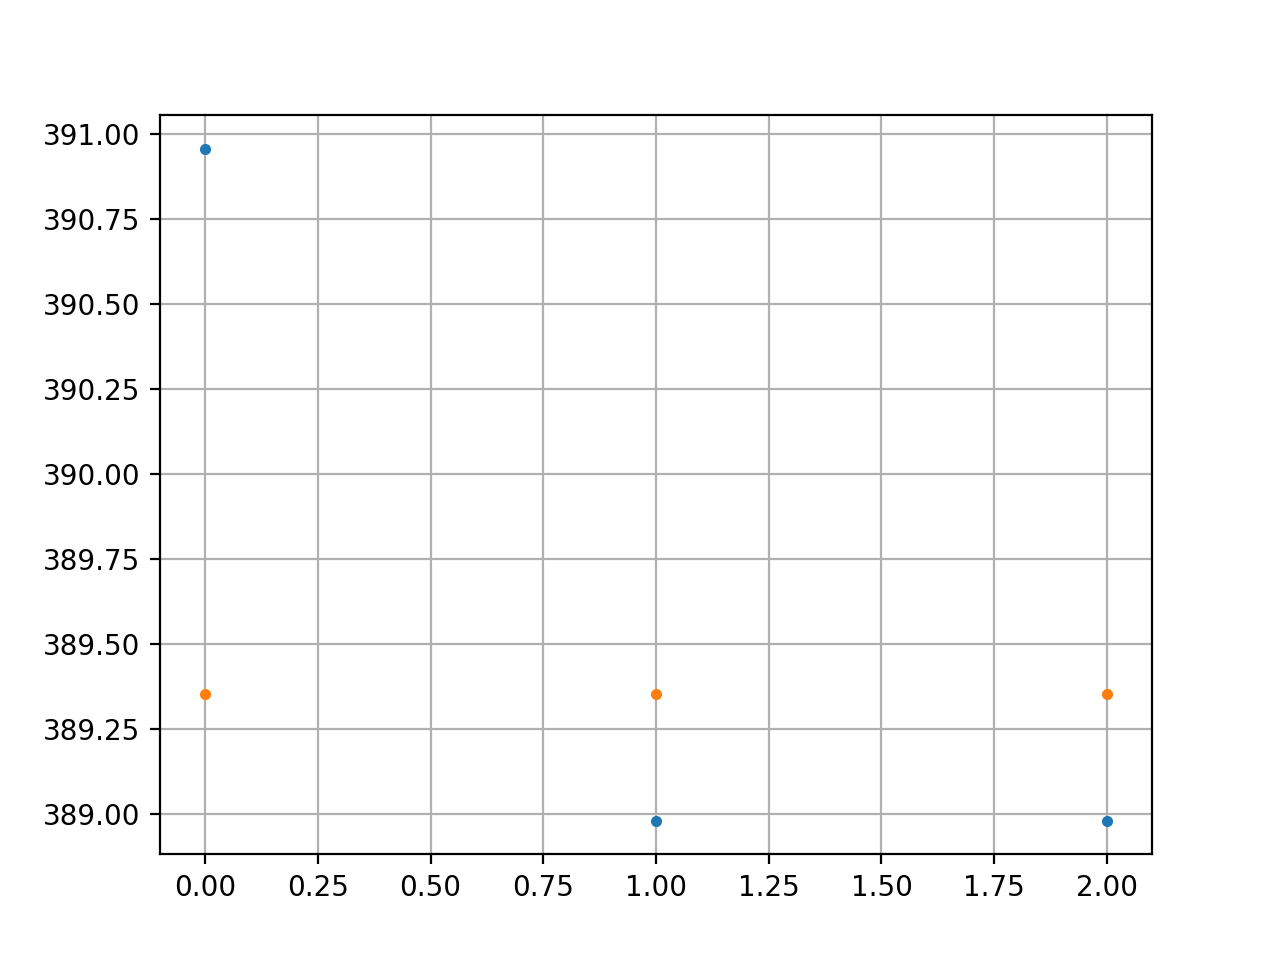

<IPython.core.display.Javascript object>


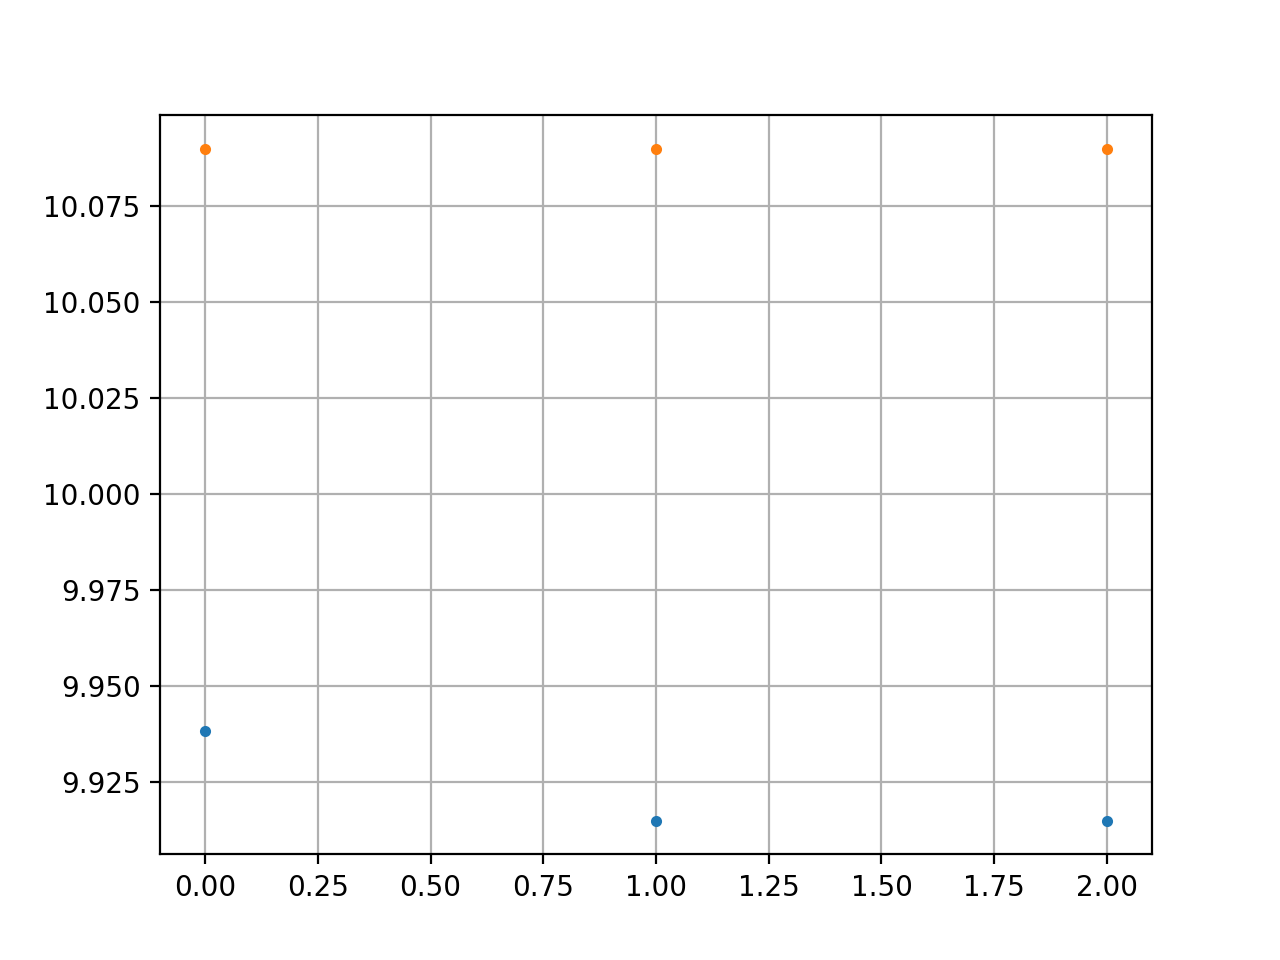

In [22]:
# acc and loss hist
plt.plot(fgn_train_res['train_loss_hist'], marker='.', linestyle=' ')
plt.plot(fgn_train_res['test_loss_hist'], marker='.', linestyle=' ')
plt.grid()
plt.show()

plt.plot(fgn_train_res['train_acc_hist'], marker='.', linestyle=' ')
plt.plot(fgn_train_res['test_acc_hist'], marker='.', linestyle=' ')
plt.grid()
plt.show()

hidden_layers.0.sigs
fl.sigs


<IPython.core.display.Javascript object>


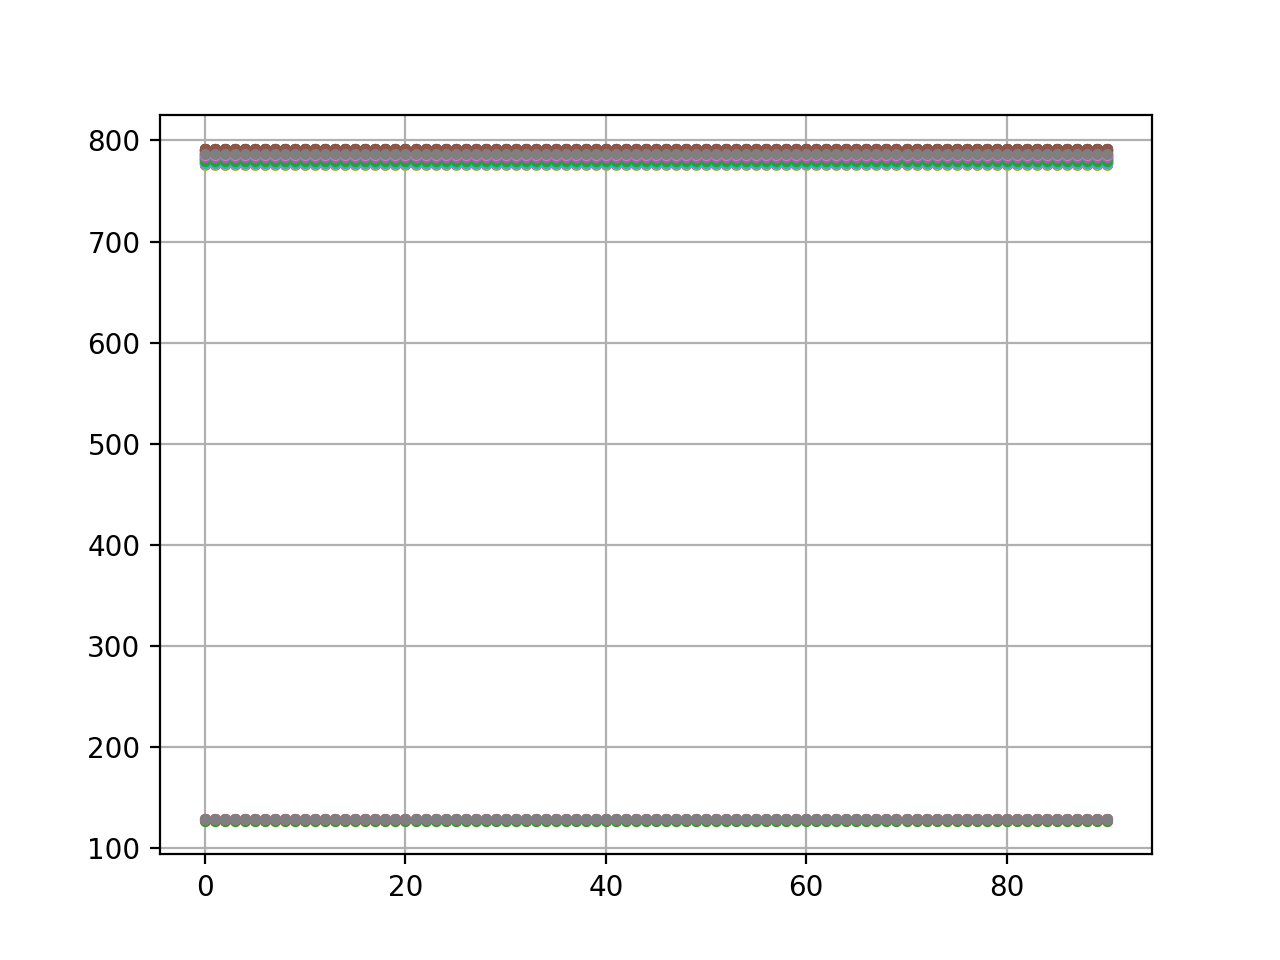

In [23]:
# plot sigma history
for k in fgn_train_res['histories'].keys():
    if 'sigs' in k:
        print(k)
        plt.plot(fgn_train_res['histories'][k][:], marker='.', linestyle=' ')
plt.grid()
plt.show()

hidden_layers.0.centers
plotting neurons: [ 86 117  81 125]


<IPython.core.display.Javascript object>


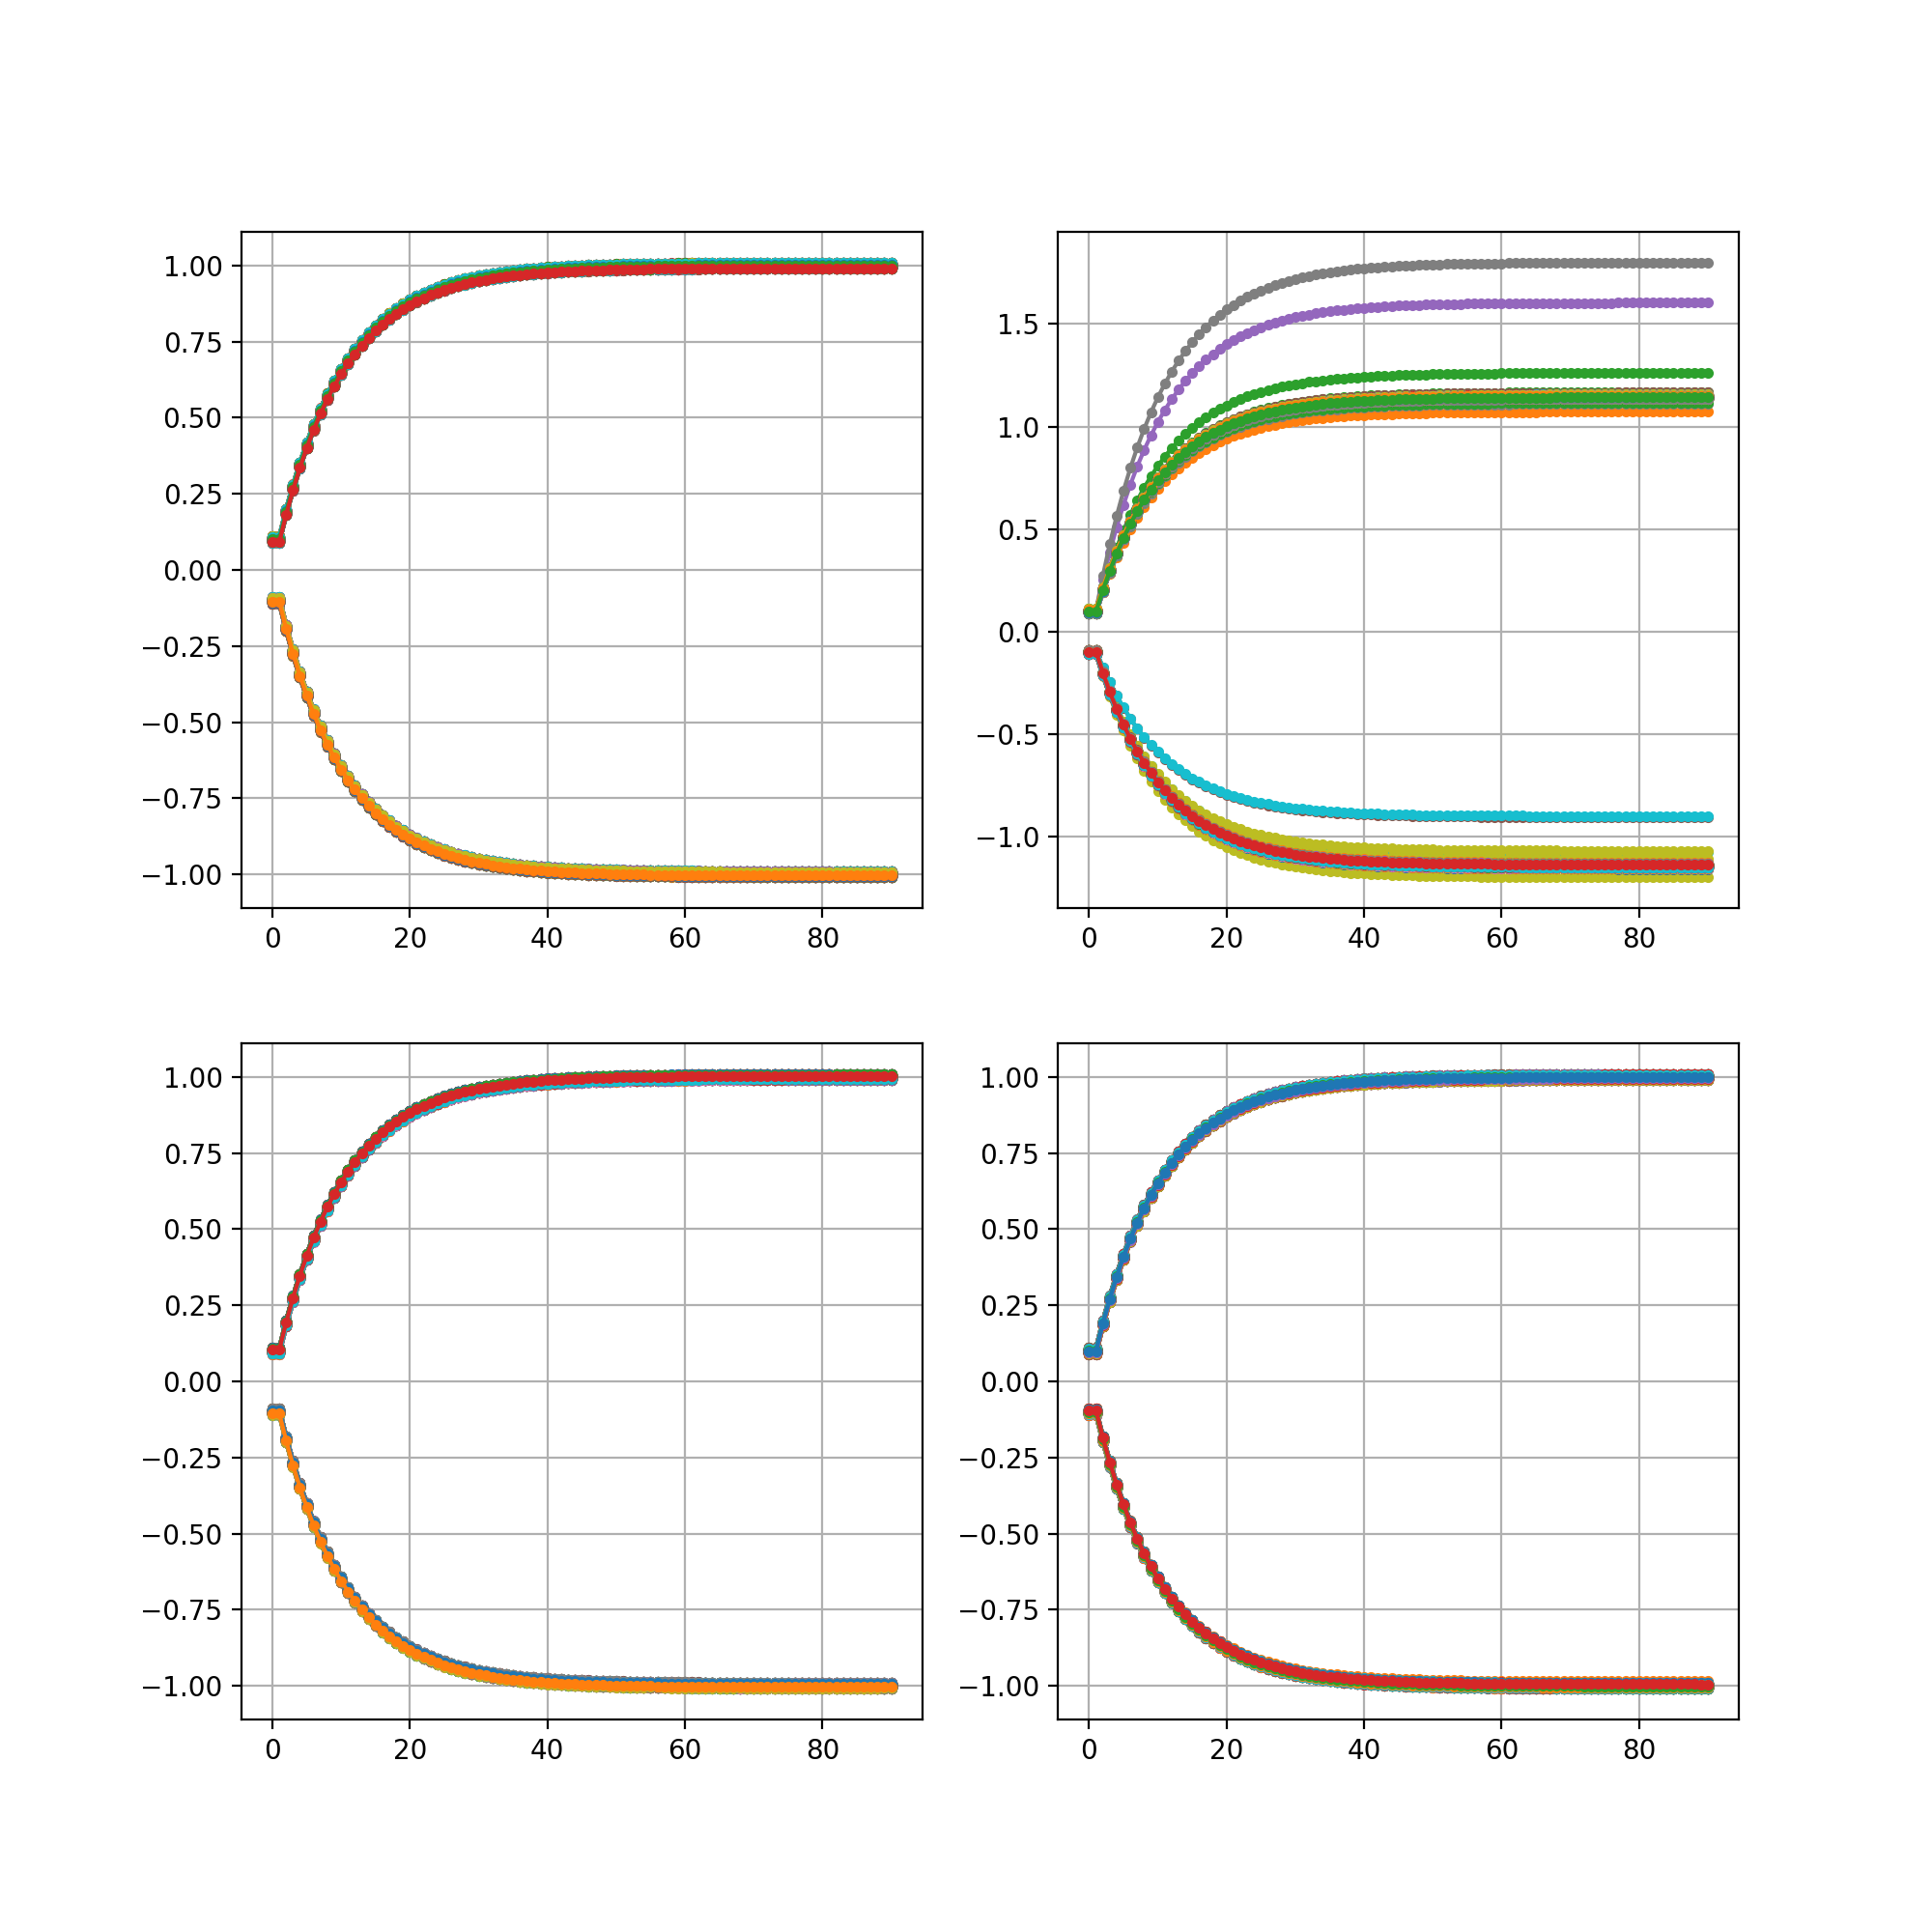

fl.centers
plotting neurons: [8 5 1 2]


<IPython.core.display.Javascript object>


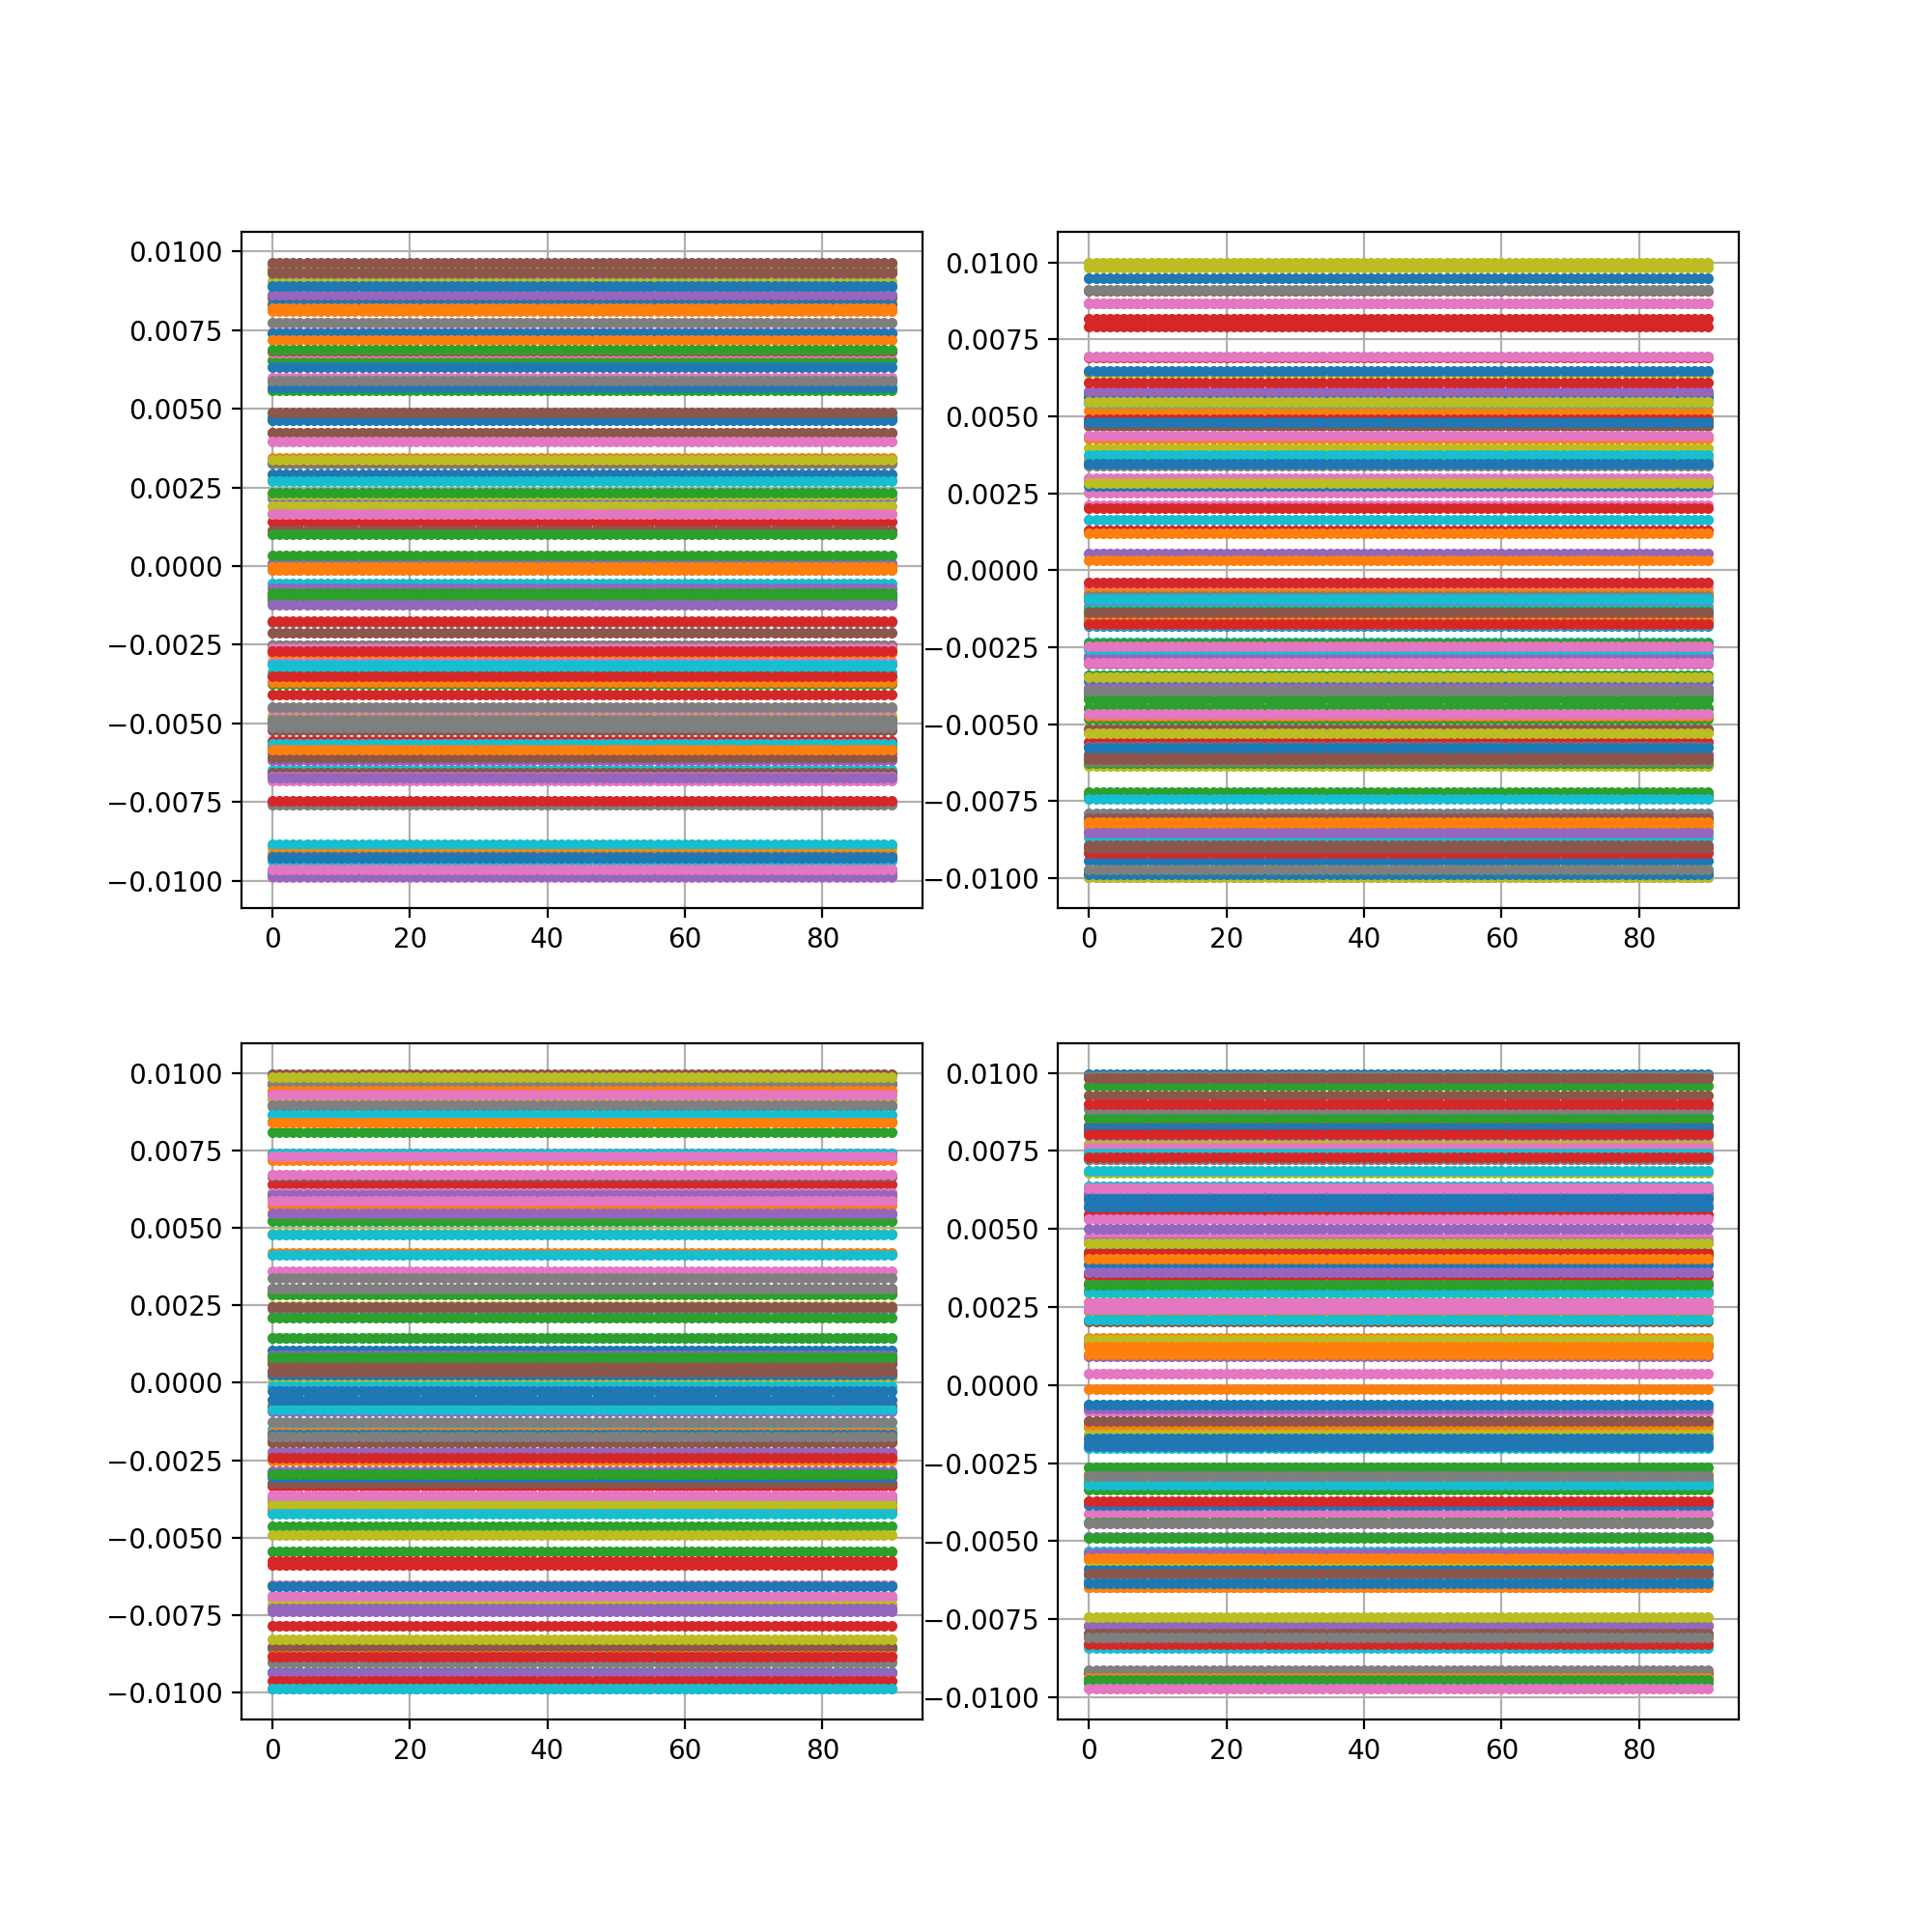

In [24]:
# plot centers history for only one neuron

for k in fgn_train_res['histories'].keys():
    if 'centers' in k:
        print(k)
        plt.figure(figsize=(10,10))
        # print(np.shape(fgn_train_res['histories'][k]))
        # choose 4random neurons in the layer to print
        neurons =  np.random.choice(range(np.shape(fgn_train_res['histories'][k])[1]),4, replace=False)
        print("plotting neurons:", neurons)
        # plt.figure(figsize=(2,2))

        for idx,n in enumerate(neurons):
            x = fgn_train_res['histories'][k][:,n,:]
            # print(np.shape(x))
            plt.subplot(2,2,idx+1)
            plt.plot(x, marker='.', linestyle='-')
            # plt.axis([-3,3, -3, 3])
            plt.grid()
        plt.show()
            
            

In [42]:
print(np.shape(fgn_train_res['histories']['hidden_layers.0.centers'][:,0,:]))

x = np.reshape(fgn_train_res['histories']['hidden_layers.0.centers'][:,0,:]
plt.imshow()

(91, 784)


In [25]:
### Next step, train only the sigmas to be minimized

In [26]:
# new loss with  potentially larger lambda
# include number of sigs in lmbda?
t_params = sum(p.numel() for p in fgn_model.parameters() if p.requires_grad)
print(t_params)
lmbda = 1.0/(len(mnist_train_loader.dataset)+t_params)
print(lmbda)


# training loss function
def training_loss_func(model, output, target):
    
    # normal NLL loss
    nll_loss = F.nll_loss(output, target.long())
#     print(nll_loss)

    for p in model.named_parameters():
        if 'sigs' in p[0]:
            try:
                sig_loss += torch.sum(p[1]**2)
            except:
                sig_loss = torch.sum(p[1]**2)
    sig_loss = lmbda*sig_loss

    return 1.0*nll_loss + 1.0*sig_loss

203402
3.79647838665e-06


In [27]:
# new optimizer for this task
# optimizer = optim.SGD([p for name,p in fgn_model.named_parameters() if p.requires_grad and 'sigs' in name], lr=0.1, momentum=0.1, nesterov=True)
optimizer = optim.Adam([p for name,p in fgn_model.named_parameters() 
                        if p.requires_grad 
                        and 'sigs' in name], 
                       lr=0.9)


In [28]:
# train
train_epochs = 3
latest_res = th.train(fgn_model, device, mnist_train_loader, training_loss_func, optimizer, 
                         epochs=train_epochs, save_hist=2, verbose=True, pred_func=fgn_pred_func, 
                         test_loader=mnist_test_loader)


if len(fgn_train_res) < 0 :
    for key in fgn_train_res.keys():
        fgn_train_res[key].extend(latest_res[key])
else:
    fgn_train_res = latest_res

Epoch 0 Train set - Average loss: 379.0678, Accuracy: 5949/60000 (10%)
Test set - Average loss: 368.4003, Accuracy: 1009/10000 (10%)
Epoch 1 Train set - Average loss: 358.0422, Accuracy: 5949/60000 (10%)
Test set - Average loss: 346.7874, Accuracy: 1009/10000 (10%)
Epoch 2 Train set - Average loss: 334.5344, Accuracy: 5823/60000 (10%)
Test set - Average loss: 317.8150, Accuracy: 958/10000 (10%)


<IPython.core.display.Javascript object>


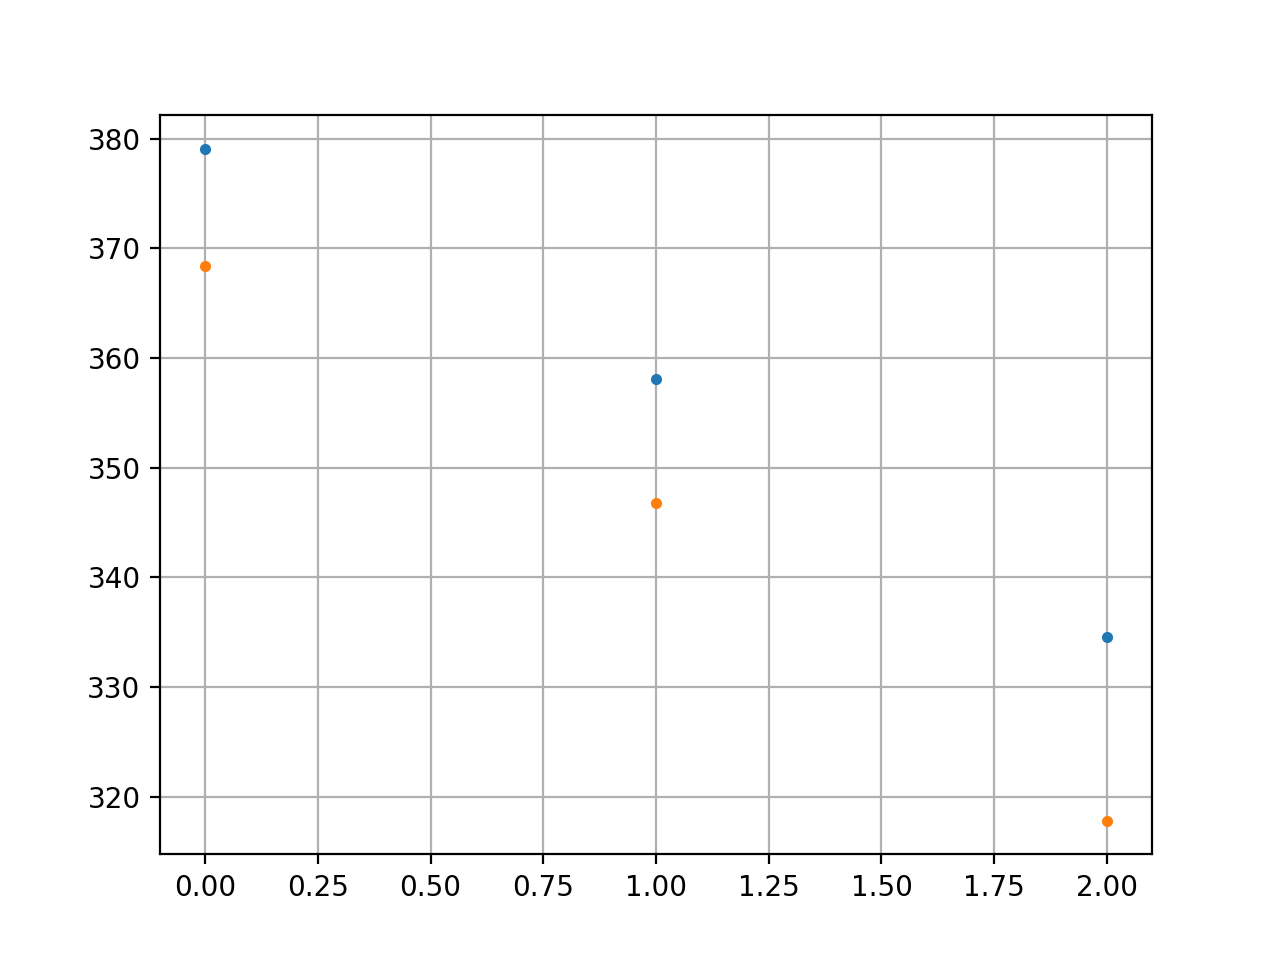

<IPython.core.display.Javascript object>


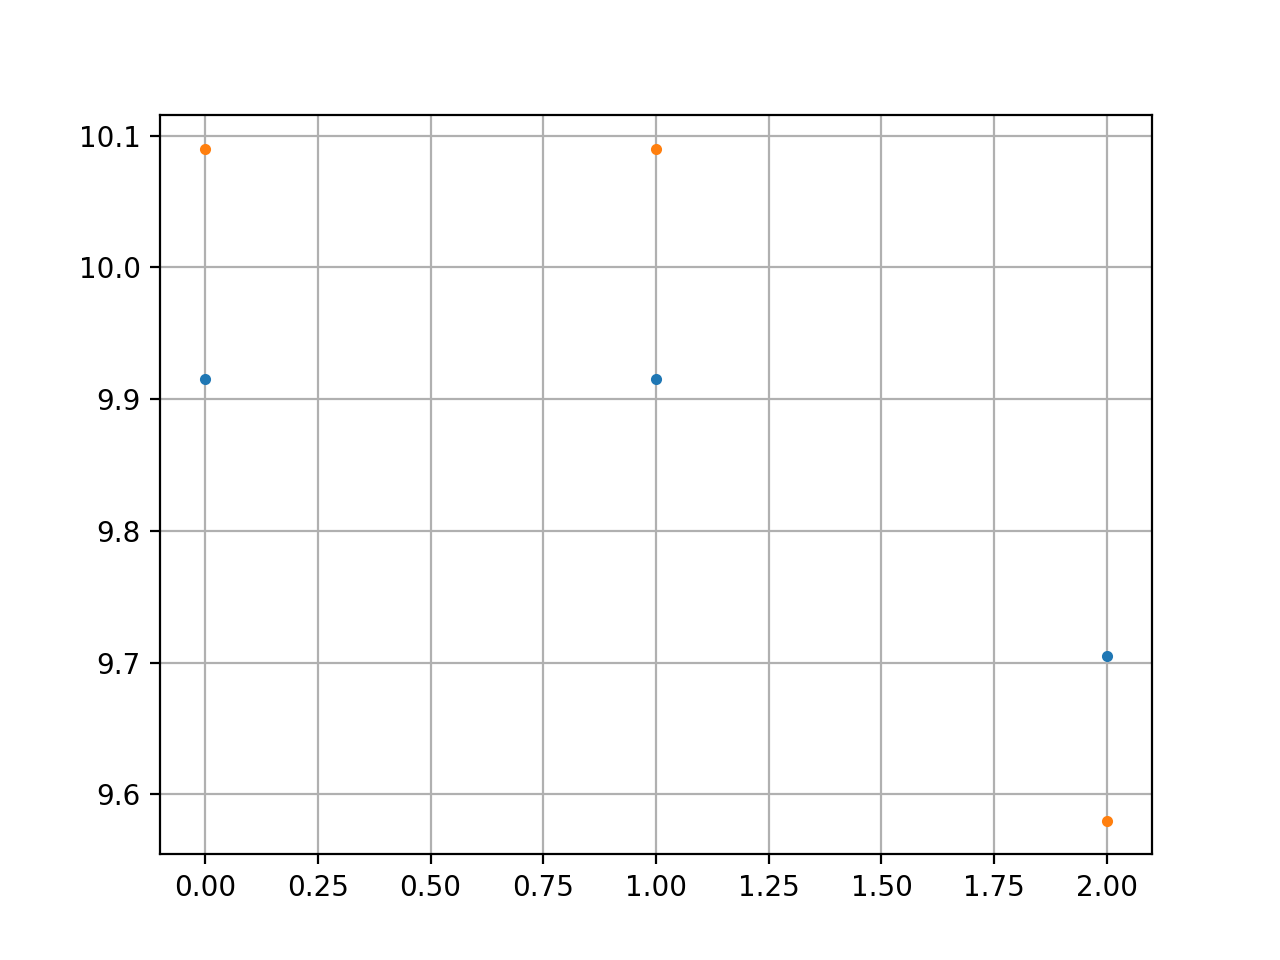

In [29]:
# acc and loss hist
plt.plot(fgn_train_res['train_loss_hist'], marker='.', linestyle=' ')
plt.plot(fgn_train_res['test_loss_hist'], marker='.', linestyle=' ')
plt.grid()
plt.show()

plt.plot(fgn_train_res['train_acc_hist'], marker='.', linestyle=' ')
plt.plot(fgn_train_res['test_acc_hist'], marker='.', linestyle=' ')
plt.grid()
plt.show()

hidden_layers.0.sigs
fl.sigs


<IPython.core.display.Javascript object>


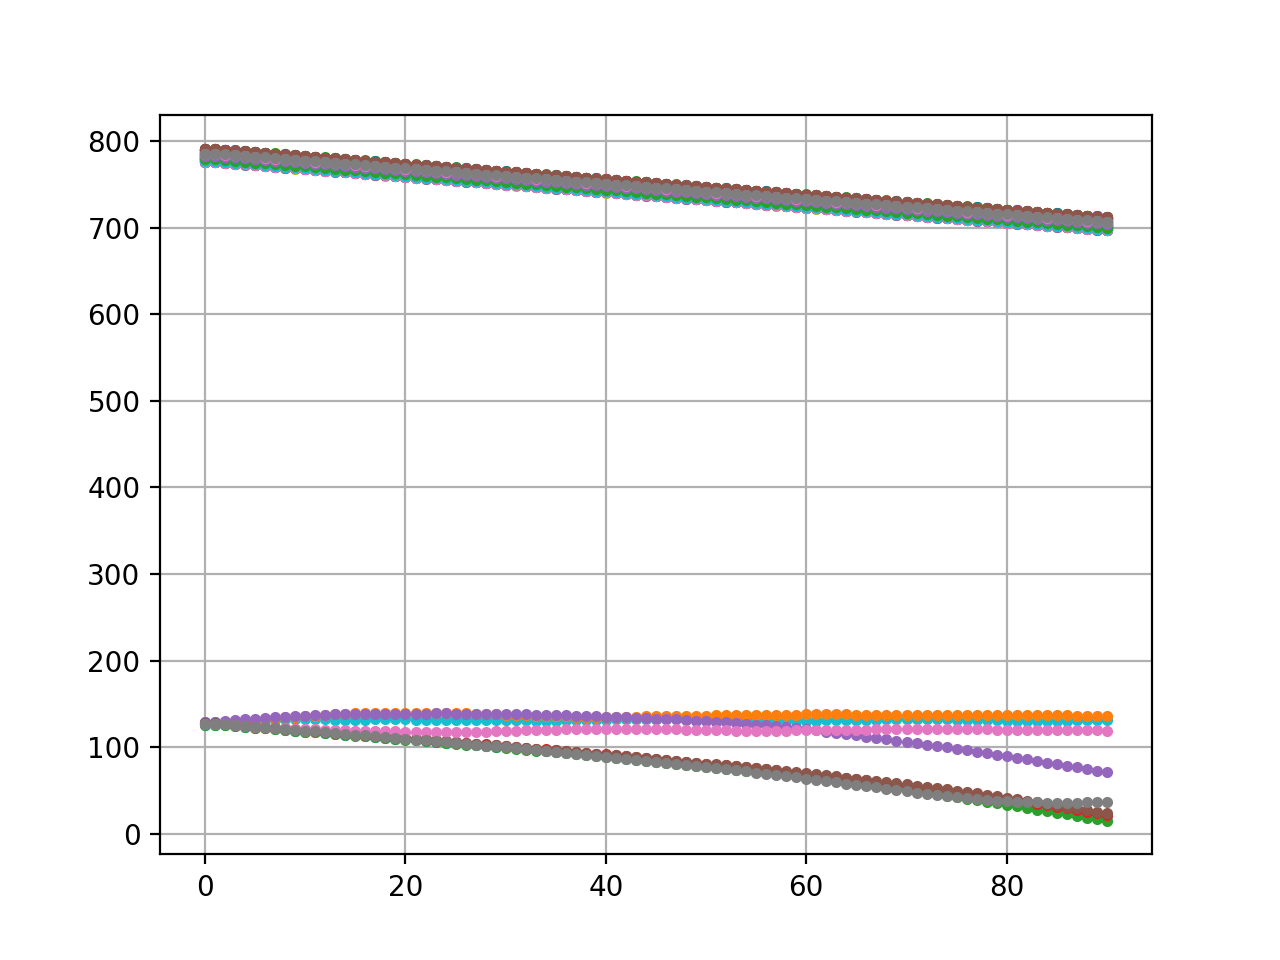

In [30]:
# plot sigma history
for k in fgn_train_res['histories'].keys():
    if 'sigs' in k:
        print(k)
        plt.plot(fgn_train_res['histories'][k][:], marker='.', linestyle=' ')
plt.grid()
plt.show()

hidden_layers.0.centers
0
(91, 784)


<IPython.core.display.Javascript object>


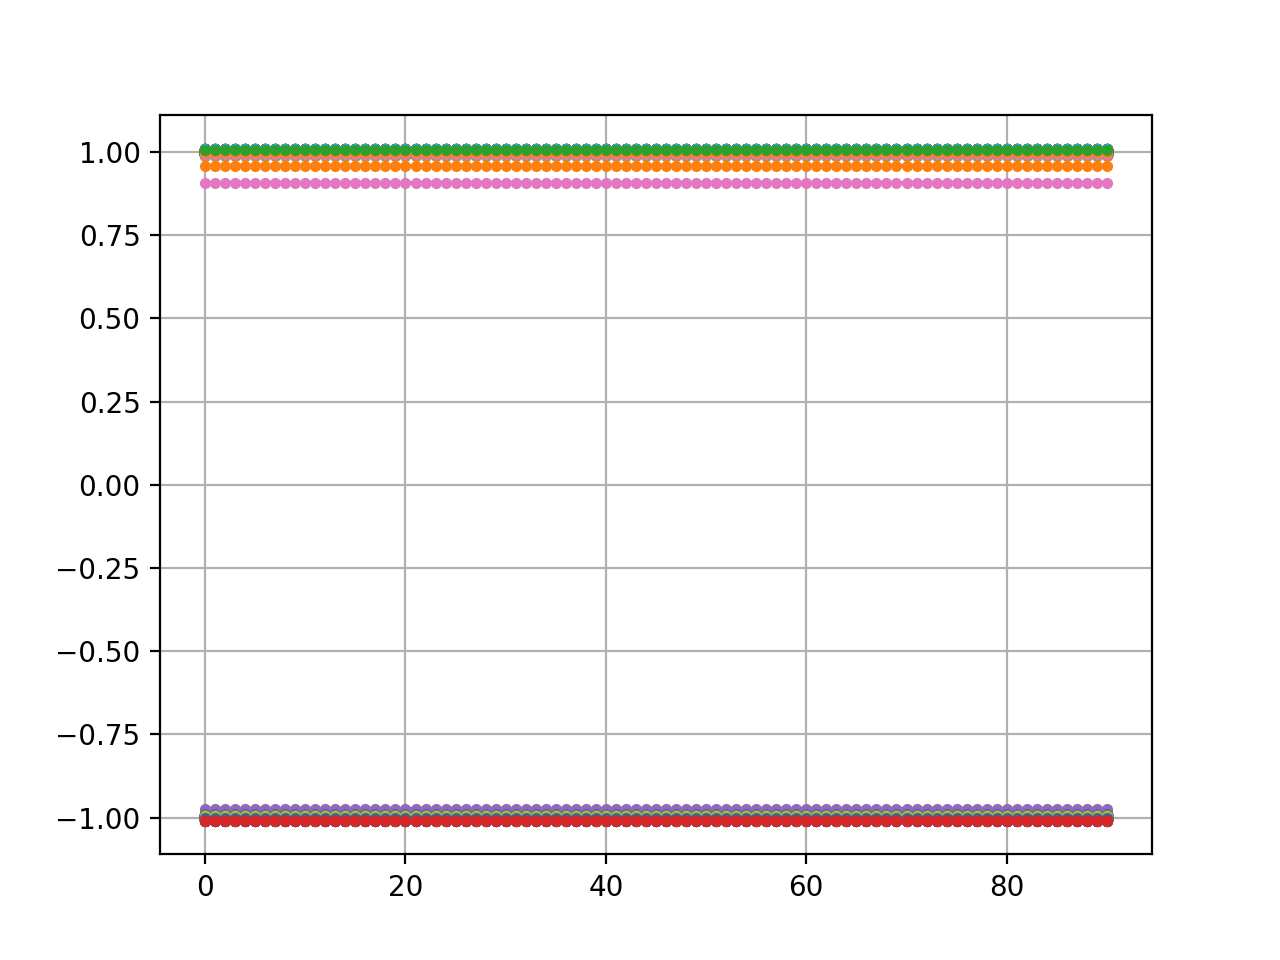

fl.centers
0
(91, 128)


<IPython.core.display.Javascript object>


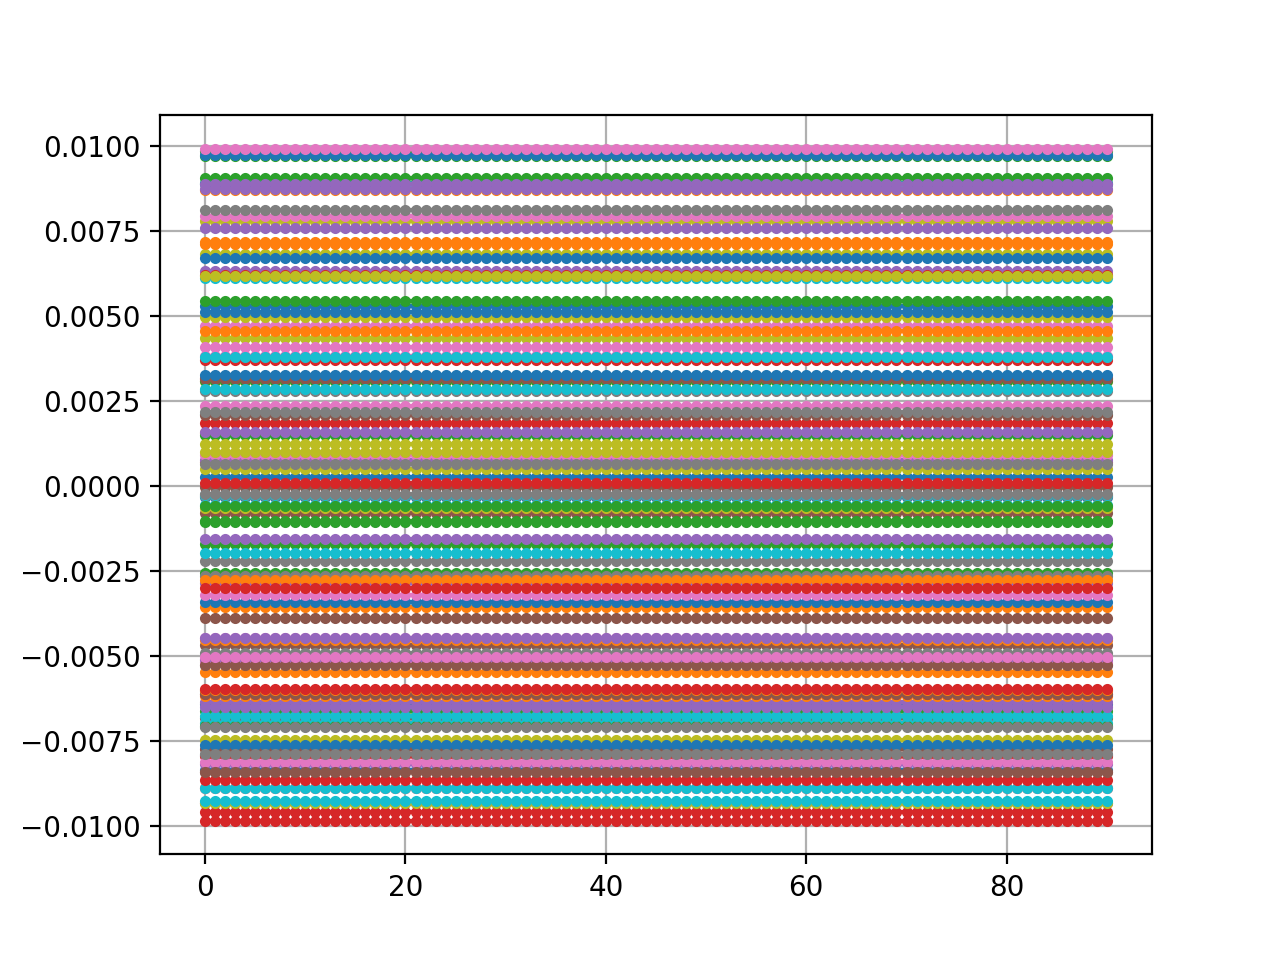

In [31]:
# check that centers havent moved
# plot centers history for only one neuron
for k in fgn_train_res['histories'].keys():
    if 'centers' in k:
        print(k)
        # print(np.shape(fgn_train_res['histories'][k]))
        for n in range(np.shape(fgn_train_res['histories'][k])[1]):
            print(n)
            x = fgn_train_res['histories'][k][:,n,:]
            print(np.shape(x))
            plt.plot(x, marker='.', linestyle='-')
            # plt.axis([-3,3, -3, 3])
            plt.grid()
            plt.show()
            
            break

In [32]:
### OLD: part where we test by making the centers of the first layer align with the data
# conclusion: didnt help, not reson ato be the good centers for loss.

In [33]:
# # if it doesn't work well, what if we start with proper centers and sigma?
# fgn_model = th.Feedforward_FGN_net(28*28,10,size).to(device)
# print("Final layer sigmas:",fgn_model.fl.sigs)
# print("Final layer centers:",fgn_model.fl.centers)

In [34]:
# print("Centers of first layer size:", fgn_model.fl.centers.size())
# # centers_from_data
# new_centers = np.mean(mnist_train_loader.dataset.train_data.view(-1, 28*28).numpy(), axis=0)
# print(new_centers.shape)
# # print(torch.Tensor(new_centers))
# # expand to match num of neurons
# new_centers = np.tile(new_centers, [10,1])
# print(new_centers.shape)
# # add some light noise
# # new_centers += np.random.uniform(0,0.0001,new_centers.shape)
# print(new_centers.shape)


# print("Sigmas of first layer size:", fgn_model.fl.sigs.size())
# # sigma from data
# new_sigmas = np.var(mnist_train_loader.dataset.train_data.view(-1, 28*28).numpy())
# print(new_sigmas.shape)
# # expand to match num of neurons
# new_sigmas = np.tile(new_sigmas, [10,])
# print(new_sigmas.shape)
# # add some light noise

# # apply
# fgn_model.state_dict()['fl.centers'].data.copy_(torch.Tensor(new_centers))
# fgn_model.state_dict()['fl.sigs'].data.copy_(torch.Tensor(new_sigmas))

In [35]:
# print("Final layer sigmas:",fgn_model.fl.sigs)
# print("Final layer centers:",fgn_model.fl.centers)

In [36]:
# # reset optimizer
# optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, fgn_model.parameters()), momentum=0.6)

In [37]:
# fgn_train_res = th.train(fgn_model, device, mnist_train_loader, training_loss_func, optimizer, epochs=train_epochs, save_hist=2, verbose=True, pred_func=fgn_pred_func, test_loader=mnist_test_loader)

In [38]:
# print("Final layer sigmas:",fgn_model.fl.sigs)
# print("Final layer centers:",fgn_model.fl.centers)